In [20]:
from google.colab import drive
import pandas as pd
import os

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# Path to your dataset inside Google Drive
file_path = '/content/drive/My Drive/DL-Assignment/IMDB Dataset.csv'

# Load dataset into a pandas DataFrame
df = pd.read_csv(file_path)

# Check the first few rows
print("Dataset shape:", df.shape)
print(df.head(5))

# Count the number of positive and negative reviews
print("\nSentiment Value Counts:")
print(df['sentiment'].value_counts())

Dataset shape: (50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Sentiment Value Counts:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [23]:
!pip install tensorflow

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
# Lowercase
df['review'] = df['review'].str.lower()

# Remove HTML tags
df['review'] = df['review'].apply(lambda x: re.sub(r'<.*?>', '', x))

# Remove punctuation (fixed with raw string)
df['review'] = df['review'].str.replace(r'[^\w\s]', '', regex=True)

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['review'] = df['review'].apply(lambda x: ' '.join([w for w in x.split() if w not in stop_words]))


In [26]:
# Label encoding
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x=='positive' else 0)

In [27]:
# Extract input features (reviews) and target labels (sentiments)
X = df['review'].values
y = df['sentiment'].values

In [28]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Set vocabulary size (top most frequent words)
vocab_size = 10000

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

In [30]:
# Fit tokenizer on training data
tokenizer.fit_on_texts(X_train)

# Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [31]:
# Set maximum sequence length
max_len = 200

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [32]:
# Display the shapes of the padded training and testing data
print("✅ Training data shape: ", (X_train_pad.shape))
print("✅ Testing data shape:  ", (X_test_pad.shape))

✅ Training data shape:  (40000, 200)
✅ Testing data shape:   (10000, 200)


In [33]:
# Build the CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


vocab_size = 10000
embedding_dim = 100
max_len = 200

model = Sequential([
    # Embedding layer
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),

    # First Convolutional Layer with L2 Regularization, Batch Normalization
    Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(l2=0.01)),
    BatchNormalization(),

    # Second Convolutional Layer with L2 Regularization, Batch Normalization
    Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(l2=0.01)),
    BatchNormalization(),

    # Third Convolutional Layer with L2 Regularization, Batch Normalization
    Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(l2=0.01)),
    BatchNormalization(),

    # MaxPooling layer
    MaxPooling1D(pool_size=2),

    # Dropout after pooling
    Dropout(0.5),

    # Flatten the output of the CNN
    Flatten(),

    # Fully connected Dense layer
    Dense(64, activation='relu' , kernel_regularizer=l2(l2=0.01)),

    # Output layer for binary classification with binary_crossentropy
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [34]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
# Train the model
history = model.fit(
    X_train_pad,
    y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

Epoch 1/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 118s 200ms/step - accuracy: 0.5367 - loss: 2.9121 - val_accuracy: 0.7495 - val_loss: 0.7865
Epoch 2/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 139s 195ms/step - accuracy: 0.8777 - loss: 0.5052 - val_accuracy: 0.8798 - val_loss: 0.4079
Epoch 3/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 114s 202ms/step - accuracy: 0.9179 - loss: 0.3167 - val_accuracy: 0.8720 - val_loss: 0.4257
Epoch 4/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 111s 198ms/step - accuracy: 0.9372 - loss: 0.2495 - val_accuracy: 0.8752 - val_loss: 0.3776
Epoch 5/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 143s 199ms/step - accuracy: 0.9533 - loss: 0.2003 - val_accuracy: 0.8677 - val_loss: 0.4002


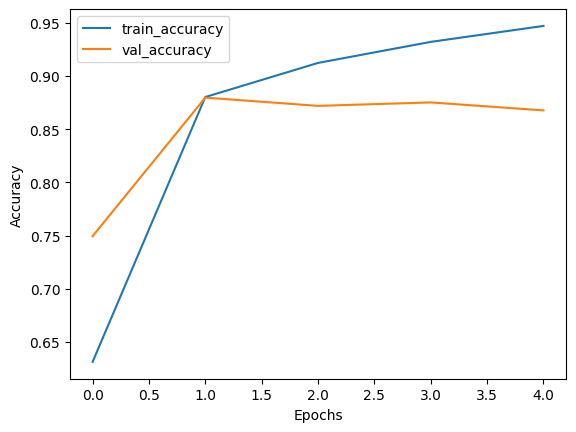

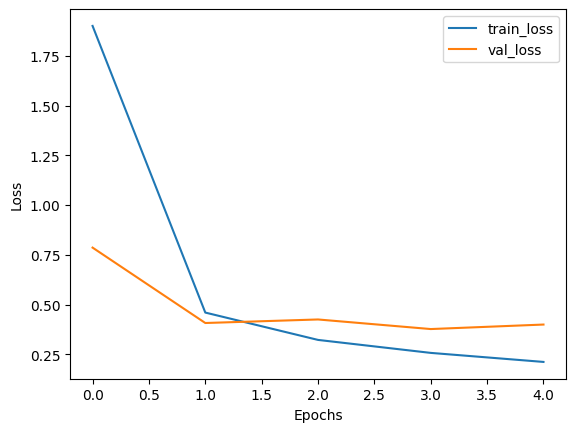

In [36]:
# Plot Training and Validation Loss/Accuracy
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
# Model evaluation with metrics
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

# Predict on test set
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Use original integer labels for true values
y_true_classes = y_test

# Compute accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Compute F1-score, precision, and recall
# Use zero_division=1 to handle cases where a class has no predicted samples
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted', zero_division=1)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted', zero_division=1)
recall = recall_score(y_true_classes, y_pred_classes, average='weighted', zero_division=1)

print(f'F1-Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Classification report for detailed metrics
print(classification_report(y_true_classes, y_pred_classes, zero_division=1))

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step
Accuracy: 0.4961
F1-Score: 0.3290
Precision: 0.7500
Recall: 0.4961
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      4961
           1       1.00      0.00      0.00      5039

    accuracy                           0.50     10000
   macro avg       0.75      0.50      0.33     10000
weighted avg       0.75      0.50      0.33     10000

